In [5]:
import torch
from utils import *
from torchvision import models
from tqdm import tqdm
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights

DATA_DIR = 'datasets/stenosis/'


def train():
    # Load data
    train_dataset = CustomImageDataset(DATA_DIR)
    data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=2,
        collate_fn=lambda batch: tuple(zip(*batch)),
    )

    # Load model
    model = models.get_model("maskrcnn_resnet50_fpn_v2", weights=None, weights_backbone=None)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    num_epochs = 1  # Define the number of epochs
    save_every = 10   # Save checkpoint every 10 iterations

    for epoch in range(num_epochs):
        print("### Epoch ", epoch + 1, "###")
        model.train()
        running_loss = 0.0
        iteration = 0
        for imgs, targets in tqdm(data_loader):
            loss_dict = model(imgs, targets)
            # Put your training logic here

            print(f"{[img.shape for img in imgs] = }")
            print(f"{[type(target) for target in targets] = }")
            for name, loss_val in loss_dict.items():
                print(f"{name:<20}{loss_val:.3f}")

            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            running_loss += losses.item()
            iteration += 1

            if iteration % save_every == 0:
                iteration_loss = running_loss / save_every
                save_checkpoint(model, optimizer, iteration, iteration_loss, filename=f"checkpoints/checkpoint_iter{iteration}")
                running_loss = 0

    if iteration % save_every != 0:  # Check if there were remaining iterations after the last save
        iteration_loss = running_loss / (iteration % save_every)
        save_checkpoint(model, optimizer, iteration, iteration_loss, filename="checkpoints/final_model.pth")


def eval(checkpoint_file, conf=0.8, k=None, num_to_plot=1, to_plot=False): 

    # load model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT).eval()    
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    load_checkpoint(model, optimizer, filename=checkpoint_file)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    base_model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT).eval()    
    params = [p for p in base_model.parameters() if p.requires_grad]
    load_checkpoint(base_model, optimizer, filename='checkpoints/checkpoint_batch4_epoch50_iter250.pth')

    # load data
    train_dataset = CustomImageDataset(DATA_DIR, 'val')
    data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=2,
        collate_fn=lambda batch: tuple(zip(*batch)),
    )

    all_outs = []
    all_tp, all_fp, all_fn = 0, 0, 0

    iteration = 0
    base_outs = []
    base_all_tp, base_all_fp, base_all_fn = 0, 0, 0
    for imgs, targets in tqdm(data_loader):  

        imgs = list(img.to(device) for img in imgs)
        print()

        with torch.no_grad():
            # We only need imgs for inference
            outputs = model(imgs)
            base_outputs = base_model(imgs)

        # Process the outputs as needed
        for i, output in enumerate(outputs):
    
            output['masks'] = output['masks'].squeeze(1)

            output['masks'][output['masks'] > conf] = 1
            output['masks'][output['masks'] <= conf] = 0


            if k is None: 
                all_outs.append((imgs[i], {
                    'boxes': output['boxes'],
                    'labels': output['labels'],
                    'scores': output['scores'],
                    'masks': output['masks']
                }))
                all_masks = output['masks']
            else: 
                topk_scores, topk_indices = torch.topk(output['scores'], k=k, largest=True)

                all_outs.append((imgs[i], {
                        'boxes': output['boxes'][topk_indices],
                        'labels': output['labels'][topk_indices],
                        'scores': output['scores'][topk_indices],
                        'masks': output['masks'][topk_indices]
                    }))
                all_masks = output['masks'][topk_indices]
            
            # Get one single mask by doing pixel wise 'or' operation on all masks
            master_mask = torch.any(all_masks.bool(), dim=0)
            target_mask = torch.any(targets[i]['masks'].bool(), dim=0)
            tp, fp, fn = get_metrics(master_mask, target_mask)
            all_tp += tp
            all_fp += fp
            all_fn += fn

        for i, b_out in enumerate(base_outputs):
            b_out['masks'] = b_out['masks'].squeeze(1)

            b_out['masks'][b_out['masks'] > conf] = 1
            b_out['masks'][b_out['masks'] <= conf] = 0

            if k is None: 
                base_outs.append((imgs[i], {
                    'boxes': b_out['boxes'],
                    'labels': b_out['labels'],
                    'scores': b_out['scores'],
                    'masks': b_out['masks']
                }))
                base_masks = b_out['masks']
            else: 
                topk_scores, topk_indices = torch.topk(b_out['scores'], k=k, largest=True)

                base_outs.append((imgs[i], {
                        'boxes': b_out['boxes'][topk_indices],
                        'labels': b_out['labels'][topk_indices],
                        'scores': b_out['scores'][topk_indices],
                        'masks': b_out['masks'][topk_indices]
                    }))
                base_masks = b_out['masks'][topk_indices]
        
        f1 = compute_f1(all_tp, all_fp, all_fn)
        print(f"F1 Score: {f1}")
        print("iteration: ", iteration)
        plot([all_outs[iteration], base_outs[iteration], train_dataset[iteration]], ['StenosisSeg-pl', 'StenosisSeg-base', 'Ground Truth'])
        iteration += 1
        if iteration == num_to_plot - 1:
            break

    
    print(f"TP: {all_tp}, FP: {all_fp}, FN: {all_fn}")
    f1 = compute_f1(all_tp, all_fp, all_fn)
    print(f"F1 Score: {f1}")

    plot([[all_outs[0], base_outs[0], train_dataset[0]],
          [all_outs[8], base_outs[8], train_dataset[8]],
          [all_outs[3], base_outs[3], train_dataset[3]]], ['StenosisSeg-pl', 'StenosisSeg-base', 'Ground Truth'])

        
    if to_plot: 
        plot([all_outs[:num_to_plot]])

In [27]:
from utils import *
tp = 767
fp = 95
fn = 368
f1 = compute_f1(tp, fp, fn)
print(f"F1 Score: {f1}")

F1 Score: 0.7681522234282622


Checkpoint loaded from epoch 19 with loss 0.1987
Checkpoint loaded from epoch 49 with loss 0.1550


  0%|          | 0/100 [00:00<?, ?it/s]


F1 Score: 0.7815384565316151
iteration:  0


  1%|          | 1/100 [00:07<12:03,  7.31s/it]


F1 Score: 0.5785785737671669
iteration:  1


  2%|▏         | 2/100 [00:19<16:49, 10.30s/it]


F1 Score: 0.6106770783440745
iteration:  2


  3%|▎         | 3/100 [00:31<17:56, 11.10s/it]


F1 Score: 0.6182735376116082
iteration:  3


  4%|▍         | 4/100 [00:43<18:19, 11.45s/it]


F1 Score: 0.6692056533253705
iteration:  4


  5%|▌         | 5/100 [00:57<19:34, 12.36s/it]


F1 Score: 0.6552304019976998
iteration:  5


  6%|▌         | 6/100 [01:12<20:28, 13.07s/it]


F1 Score: 0.6568555586939737
iteration:  6


  7%|▋         | 7/100 [01:29<22:14, 14.35s/it]


F1 Score: 0.637211817068322
iteration:  7


  8%|▊         | 8/100 [01:42<21:17, 13.88s/it]


F1 Score: 0.6354912026344537
iteration:  8


  8%|▊         | 8/100 [01:54<21:53, 14.27s/it]


TP: 5728, FP: 3473, FN: 3098
F1 Score: 0.6354912026344537


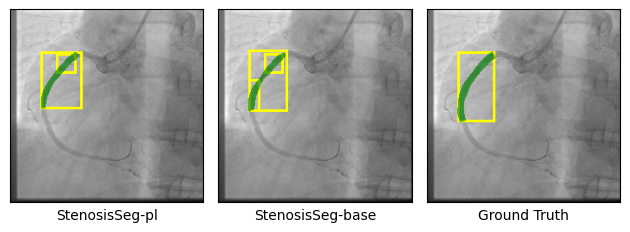

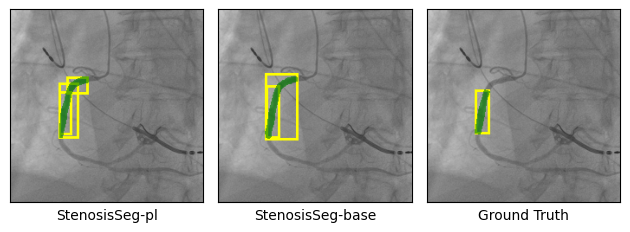

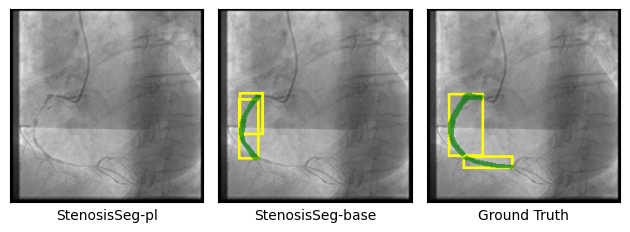

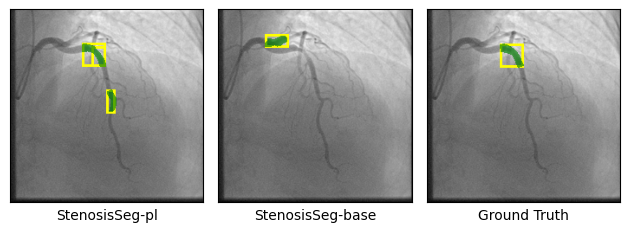

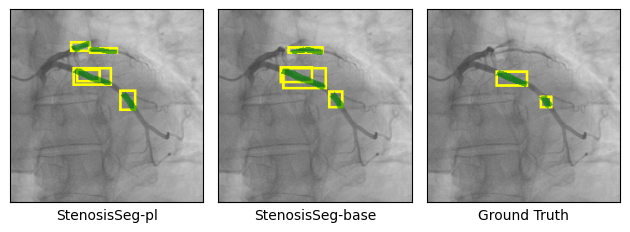

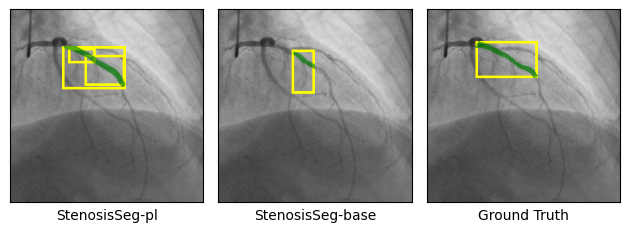

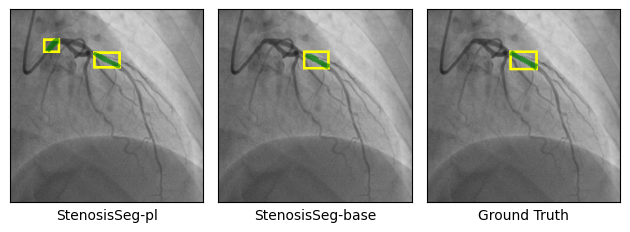

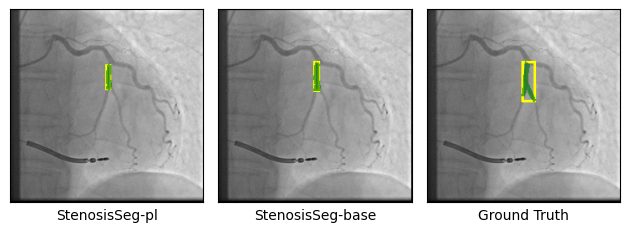

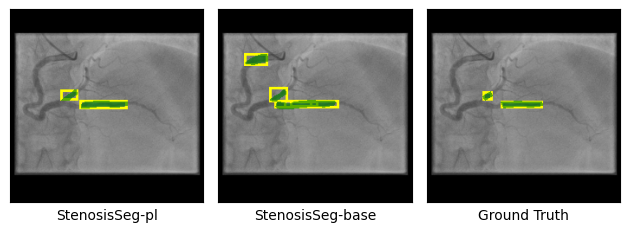

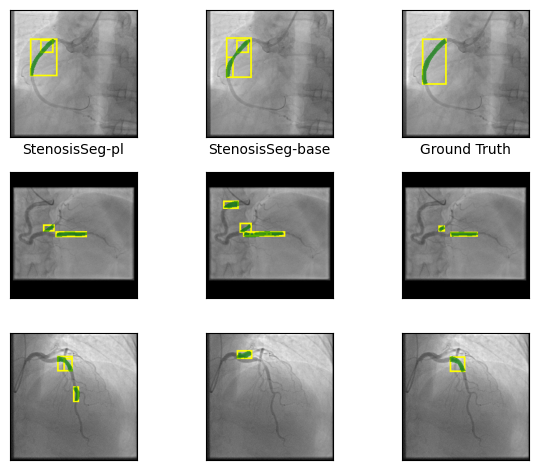

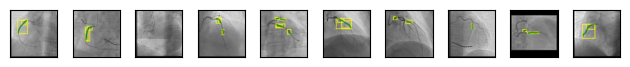

In [6]:
eval("checkpoints/checkpoint_batch4_epoch20_iter500_pseudo_new.pth", conf=0.55, num_to_plot=10, k=None, to_plot=True)

In [59]:
train_dataset = CustomImageDataset(DATA_DIR)
data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    collate_fn=lambda batch: tuple(zip(*batch)),
)

for imgs, target in data_loader:
    print(f"{[img.shape for img in imgs] = }")
    print(f"{[type(target) for target in target] = }")
    print(f"{[target['masks'].dtype for target in target] = }")
    break

[img.shape for img in imgs] = [torch.Size([3, 224, 224]), torch.Size([3, 224, 224])]
[type(target) for target in target] = [<class 'dict'>, <class 'dict'>]
[target['masks'].dtype for target in target] = [torch.uint8, torch.uint8]


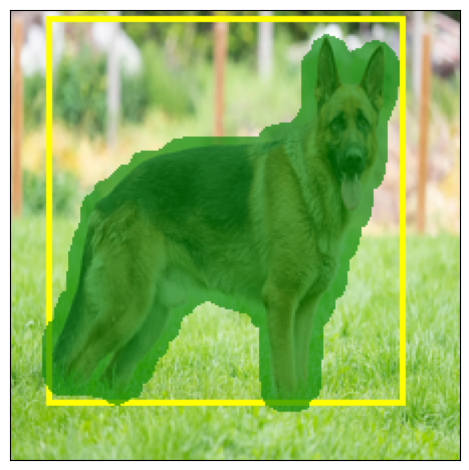

In [15]:
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights

# model = models.get_model("maskrcnn_resnet50_fpn_v2", weights=None, weights_backbone=None).eval()
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT).eval()
all_outs = []
img = Image.open("dog.png")
img = pil_to_tensor(img.resize((224, 224)))
img = img.to(torch.float32)
img = img / 255.0
output = model([img])
output = output[0]
output['masks'] = output['masks'].squeeze(1)
output['masks'][output['masks'] > 0.05] = 1
output['masks'][output['masks'] <= 0.05] = 0
topk_scores, topk_indices = torch.topk(output['scores'], k=1, largest=True)
all_outs.append((img, {
                    'boxes': output['boxes'][topk_indices],
                    'labels': output['labels'][topk_indices],
                    'scores': output['scores'][topk_indices],
                    'masks': output['masks'][topk_indices]
                }))

plot([all_outs[0]])